In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
root_path = Path(os.getcwd()).resolve().parent

In [3]:
sys.path.append(str(root_path))

In [4]:
pd.set_option('display.max_columns',500)

In [5]:
df = pd.read_csv("../data/processed/heart_attack_prediction_dataset1_processed.csv")

In [6]:
data = df.copy()

In [7]:
data

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST,EnfermedadCardiaca
0,59,M,ASY,156,96.0,0,LVH,177,Y,1.6,Flat,1
1,57,M,ASY,135,413.0,0,Normal,125,Y,-0.1,Up,1
2,58,M,ATA,130,410.0,0,Normal,124,N,1.2,Up,1
3,65,M,ASY,134,149.0,0,ST,190,N,1.0,Flat,1
4,57,F,ATA,125,156.0,0,Normal,140,Y,-0.1,Flat,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18557,53,M,ASY,161,8.0,0,Normal,100,Y,2.0,Up,0
18558,56,M,ASY,127,60.0,0,Normal,124,N,-0.1,Flat,0
18559,55,M,ASY,144,517.0,0,Normal,112,Y,-0.1,Up,1
18560,60,M,ASY,130,253.0,0,Normal,144,Y,0.1,Up,1


Transformar las varibales categoricas nominales a categoricas ordinales

Tabla con descripcion de cada variable

Separación del conjunto de datos en features y target

In [8]:
X = data.drop(columns='EnfermedadCardiaca')

In [9]:
y = data['EnfermedadCardiaca']

Transformando las variables utilizando onehotencoder para evitar que el modelo interprete cada variable utilizando diferentes pesos

In [10]:
X_scaled = X.copy()

In [11]:
categorical_cols = X_scaled.select_dtypes(include=["object"]).columns

In [12]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_scaled[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store the encoder if you need to inverse transform later

Analisis de la escala de cada variable

In [13]:
X_scaled

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST
0,59,1,0,156,96.0,0,0,177,1,1.6,1
1,57,1,0,135,413.0,0,1,125,1,-0.1,2
2,58,1,1,130,410.0,0,1,124,0,1.2,2
3,65,1,0,134,149.0,0,2,190,0,1.0,1
4,57,0,1,125,156.0,0,1,140,1,-0.1,1
...,...,...,...,...,...,...,...,...,...,...,...
18557,53,1,0,161,8.0,0,1,100,1,2.0,2
18558,56,1,0,127,60.0,0,1,124,0,-0.1,1
18559,55,1,0,144,517.0,0,1,112,1,-0.1,2
18560,60,1,0,130,253.0,0,1,144,1,0.1,2


In [14]:
X_scaled.describe()

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST
count,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000
mean,56.207844,0.788223,0.783051,132.015354,209.013719,0.043907,0.985293,136.584204,0.402112,0.649100,1.366609
std,8.793589,0.408578,0.958808,18.440124,97.482676,0.204894,0.630945,25.388117,0.490337,0.998975,0.603771
min,28.000000,0.000000,0.000000,59.000000,1.000000,0.000000,0.000000,60.000000,0.000000,-1.600000,0.000000
25%,50.000000,1.000000,0.000000,120.000000,141.000000,0.000000,1.000000,119.000000,0.000000,-0.100000,1.000000
50%,56.000000,1.000000,0.000000,132.000000,209.013719,0.000000,1.000000,137.000000,0.000000,0.200000,1.000000
75%,62.000000,1.000000,2.000000,144.000000,271.000000,0.000000,1.000000,154.000000,1.000000,1.300000,2.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,5.700000,2.000000


Se nota que los datos no están escalados, lo que puede causar problemas durante los estudos realizados aquí en este conjunto de datos. Utilizaremos el metodo StandardScaler de la libreria Sklearn para transformar nuestros datos.

In [15]:
numerical_cols = X_scaled.select_dtypes(include=['int64', 'float64']).columns

In [16]:
scaler = MinMaxScaler()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

In [17]:
X_scaled

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST
0,0.632653,1.0,0.000000,0.687943,0.157807,0.0,0.0,0.823944,1.0,0.438356,0.5
1,0.591837,1.0,0.000000,0.539007,0.684385,0.0,0.5,0.457746,1.0,0.205479,1.0
2,0.612245,1.0,0.333333,0.503546,0.679402,0.0,0.5,0.450704,0.0,0.383562,1.0
3,0.755102,1.0,0.000000,0.531915,0.245847,0.0,1.0,0.915493,0.0,0.356164,0.5
4,0.591837,0.0,0.333333,0.468085,0.257475,0.0,0.5,0.563380,1.0,0.205479,0.5
...,...,...,...,...,...,...,...,...,...,...,...
18557,0.510204,1.0,0.000000,0.723404,0.011628,0.0,0.5,0.281690,1.0,0.493151,1.0
18558,0.571429,1.0,0.000000,0.482270,0.098007,0.0,0.5,0.450704,0.0,0.205479,0.5
18559,0.551020,1.0,0.000000,0.602837,0.857143,0.0,0.5,0.366197,1.0,0.205479,1.0
18560,0.653061,1.0,0.000000,0.503546,0.418605,0.0,0.5,0.591549,1.0,0.232877,1.0


In [18]:
X_scaled.describe()

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST
count,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000,18562.000000
mean,0.575670,0.788223,0.261017,0.517839,0.345538,0.043907,0.492646,0.539325,0.402112,0.308096,0.683305
std,0.179461,0.408578,0.319603,0.130781,0.161931,0.204894,0.315473,0.178790,0.490337,0.136846,0.301886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.448980,1.000000,0.000000,0.432624,0.232558,0.000000,0.500000,0.415493,0.000000,0.205479,0.500000
50%,0.571429,1.000000,0.000000,0.517730,0.345538,0.000000,0.500000,0.542254,0.000000,0.246575,0.500000
75%,0.693878,1.000000,0.666667,0.602837,0.448505,0.000000,0.500000,0.661972,1.000000,0.397260,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Resumen de preprocesamento

* Separacion de los datos en X e y
    * X = Conjunto de todas las variables excepto la columna target
    * y = columna target, variable que identifica se el paciente tiene problema cardiaco o no.
* Tratamiento de la X
    * Transformacción de las variables a traves de la libreria OneHotEncoder
    * Escalar las variables a traves del metodo StandardScaler

Reducción de dimensionalidad utilizando PCA

In [19]:
pca = PCA(n_components=.95)

In [20]:
X_scaled_pca = pca.fit_transform(X_scaled)

In [21]:
X_scaled_pca

array([[ 0.60724143,  0.20084961, -0.08245796, ..., -0.13804687,
         0.24952806, -0.20196014],
       [ 0.60151323,  0.20256874, -0.1811511 , ...,  0.06488079,
        -0.03939176,  0.33937308],
       [-0.40404589,  0.21678804,  0.10827548, ...,  0.0963096 ,
        -0.03876903,  0.3350667 ],
       ...,
       [ 0.60268218,  0.20329205, -0.182532  , ...,  0.09417574,
        -0.13117184,  0.51400498],
       [ 0.59974861,  0.20152502, -0.17900468, ...,  0.02500732,
         0.09564513,  0.07016078],
       [-0.41125013, -0.77777854,  0.51671199, ..., -0.01587353,
        -0.18237487,  0.03559849]])

In [22]:
pca.explained_variance_ratio_

array([0.27700487, 0.19225386, 0.11860973, 0.11407172, 0.10453361,
       0.04831074, 0.03785979, 0.03595105, 0.03017679])

In [23]:
pca.explained_variance_ratio_.cumsum()

array([0.27700487, 0.46925873, 0.58786846, 0.70194017, 0.80647378,
       0.85478453, 0.89264432, 0.92859537, 0.95877216])

* Varianza explicada:
    * Las diez columnas selecionadas por el PCA retienen el 95.37% de la información relevante.
* Componentes marginales:
    * Los otros componentes aportan información mínima que no sumaria para la mejora del modelo.


Separacion del conjunto de datos entre datos de entrenamiento y prueba

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
X_scaled_pca, X_test_pca, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [26]:
# Define models (default hyperparameters)
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Train and evaluate models on both original and scaled data
for name, model in models.items():
    
    print(f"Training {name} on Scaled Data...")
    model.fit(X_train, y_train)
    preds_scaled = model.predict(X_test)
    acc_scaled = accuracy_score(y_test, preds_scaled)

    print(f"Training {name} on Scaled Data with PCA...")
    model.fit(X_scaled_pca, y_train)
    preds_scaled = model.predict(X_test_pca)
    acc_scaled_pca = accuracy_score(y_test, preds_scaled)
    
    print(f"{name} - Accuracy on Original: {acc_scaled_pca:.4f}, Accuracy on Scaled: {acc_scaled:.4f}")
    print("-" * 50)


Training SVM on Scaled Data...
Training SVM on Scaled Data with PCA...
SVM - Accuracy on Original: 0.5333, Accuracy on Scaled: 0.5333
--------------------------------------------------
Training Logistic Regression on Scaled Data...
Training Logistic Regression on Scaled Data with PCA...
Logistic Regression - Accuracy on Original: 0.5316, Accuracy on Scaled: 0.5316
--------------------------------------------------
Training KNN on Scaled Data...
Training KNN on Scaled Data with PCA...
KNN - Accuracy on Original: 0.5176, Accuracy on Scaled: 0.5176
--------------------------------------------------
Training Decision Tree on Scaled Data...
Training Decision Tree on Scaled Data with PCA...
Decision Tree - Accuracy on Original: 0.5007, Accuracy on Scaled: 0.5034
--------------------------------------------------
Training Random Forest on Scaled Data...
Training Random Forest on Scaled Data with PCA...
Random Forest - Accuracy on Original: 0.5211, Accuracy on Scaled: 0.5190
------------------

Training SVM on Scaled Data...
Confusion Matrix (Scaled Data) for SVM:


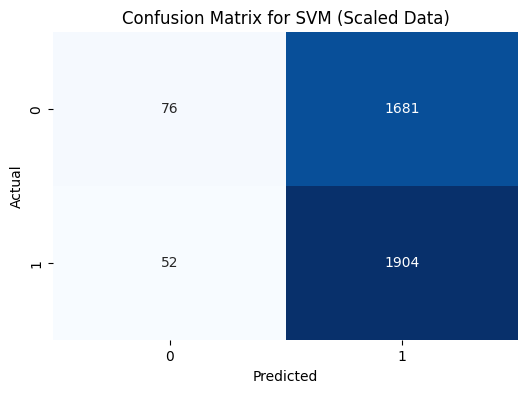

Classification Report (Scaled Data) for SVM:

              precision    recall  f1-score   support

           0       0.59      0.04      0.08      1757
           1       0.53      0.97      0.69      1956

    accuracy                           0.53      3713
   macro avg       0.56      0.51      0.38      3713
weighted avg       0.56      0.53      0.40      3713

--------------------------------------------------
Training SVM on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for SVM:


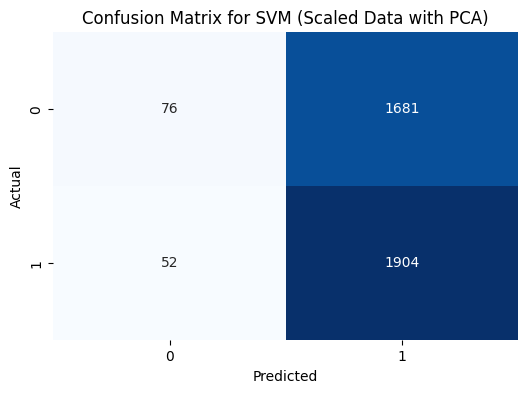

Classification Report (Scaled Data with PCA) for SVM:

              precision    recall  f1-score   support

           0       0.59      0.04      0.08      1757
           1       0.53      0.97      0.69      1956

    accuracy                           0.53      3713
   macro avg       0.56      0.51      0.38      3713
weighted avg       0.56      0.53      0.40      3713

--------------------------------------------------
Training Logistic Regression on Scaled Data...
Confusion Matrix (Scaled Data) for Logistic Regression:


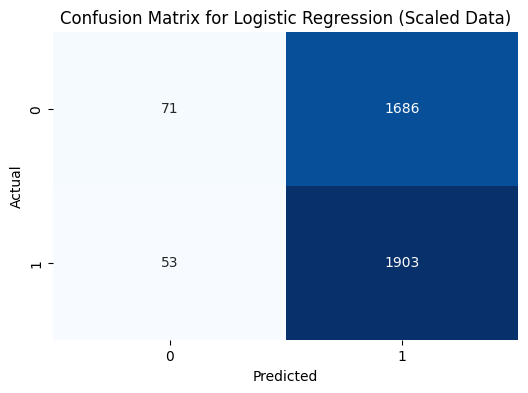

Classification Report (Scaled Data) for Logistic Regression:

              precision    recall  f1-score   support

           0       0.57      0.04      0.08      1757
           1       0.53      0.97      0.69      1956

    accuracy                           0.53      3713
   macro avg       0.55      0.51      0.38      3713
weighted avg       0.55      0.53      0.40      3713

--------------------------------------------------
Training Logistic Regression on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for Logistic Regression:


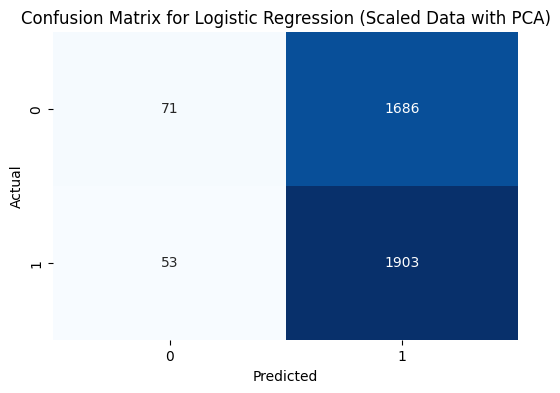

Classification Report (Scaled Data with PCA) for Logistic Regression:

              precision    recall  f1-score   support

           0       0.57      0.04      0.08      1757
           1       0.53      0.97      0.69      1956

    accuracy                           0.53      3713
   macro avg       0.55      0.51      0.38      3713
weighted avg       0.55      0.53      0.40      3713

--------------------------------------------------
Training KNN on Scaled Data...
Confusion Matrix (Scaled Data) for KNN:


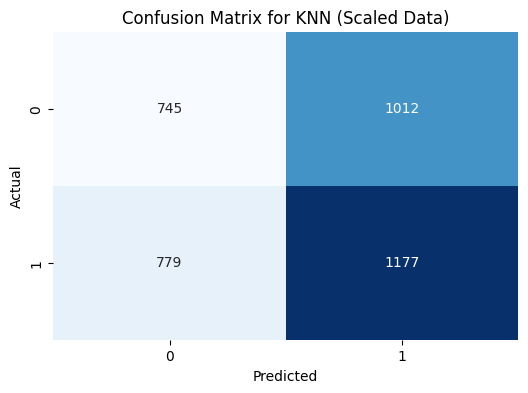

Classification Report (Scaled Data) for KNN:

              precision    recall  f1-score   support

           0       0.49      0.42      0.45      1757
           1       0.54      0.60      0.57      1956

    accuracy                           0.52      3713
   macro avg       0.51      0.51      0.51      3713
weighted avg       0.51      0.52      0.51      3713

--------------------------------------------------
Training KNN on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for KNN:


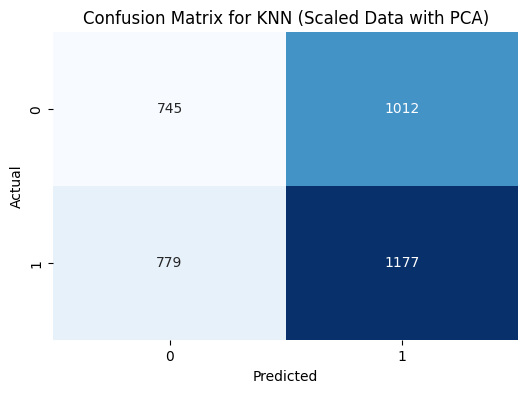

Classification Report (Scaled Data with PCA) for KNN:

              precision    recall  f1-score   support

           0       0.49      0.42      0.45      1757
           1       0.54      0.60      0.57      1956

    accuracy                           0.52      3713
   macro avg       0.51      0.51      0.51      3713
weighted avg       0.51      0.52      0.51      3713

--------------------------------------------------
Training Decision Tree on Scaled Data...
Confusion Matrix (Scaled Data) for Decision Tree:


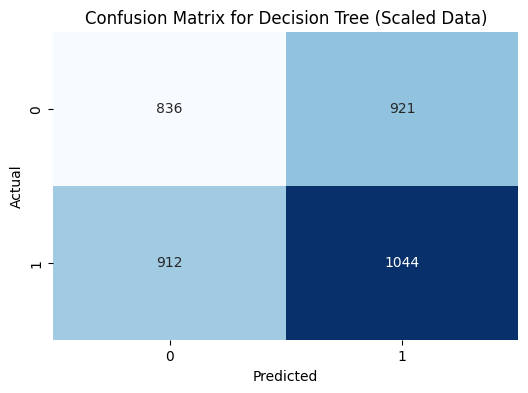

Classification Report (Scaled Data) for Decision Tree:

              precision    recall  f1-score   support

           0       0.48      0.48      0.48      1757
           1       0.53      0.53      0.53      1956

    accuracy                           0.51      3713
   macro avg       0.50      0.50      0.50      3713
weighted avg       0.51      0.51      0.51      3713

--------------------------------------------------
Training Decision Tree on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for Decision Tree:


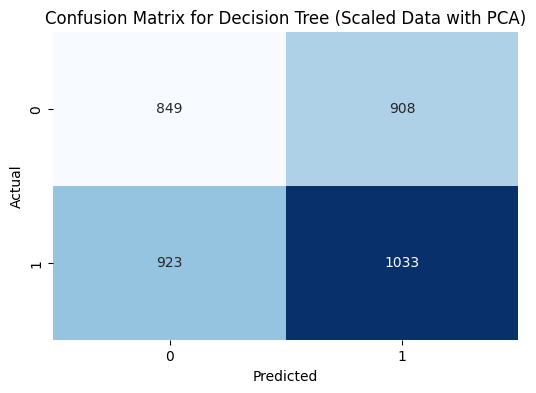

Classification Report (Scaled Data with PCA) for Decision Tree:

              precision    recall  f1-score   support

           0       0.48      0.48      0.48      1757
           1       0.53      0.53      0.53      1956

    accuracy                           0.51      3713
   macro avg       0.51      0.51      0.51      3713
weighted avg       0.51      0.51      0.51      3713

--------------------------------------------------
Training Random Forest on Scaled Data...
Confusion Matrix (Scaled Data) for Random Forest:


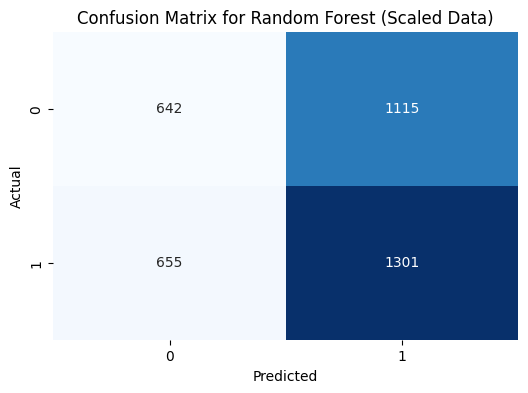

Classification Report (Scaled Data) for Random Forest:

              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1757
           1       0.54      0.67      0.60      1956

    accuracy                           0.52      3713
   macro avg       0.52      0.52      0.51      3713
weighted avg       0.52      0.52      0.51      3713

--------------------------------------------------
Training Random Forest on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for Random Forest:


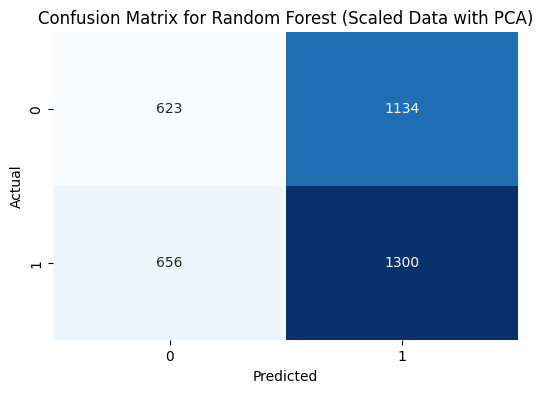

Classification Report (Scaled Data with PCA) for Random Forest:

              precision    recall  f1-score   support

           0       0.49      0.35      0.41      1757
           1       0.53      0.66      0.59      1956

    accuracy                           0.52      3713
   macro avg       0.51      0.51      0.50      3713
weighted avg       0.51      0.52      0.51      3713

--------------------------------------------------
Training XGBoost on Scaled Data...
Confusion Matrix (Scaled Data) for XGBoost:


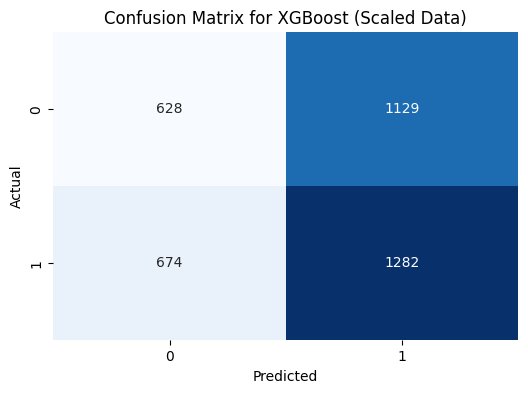

Classification Report (Scaled Data) for XGBoost:

              precision    recall  f1-score   support

           0       0.48      0.36      0.41      1757
           1       0.53      0.66      0.59      1956

    accuracy                           0.51      3713
   macro avg       0.51      0.51      0.50      3713
weighted avg       0.51      0.51      0.50      3713

--------------------------------------------------
Training XGBoost on Scaled Data with PCA...
Confusion Matrix (Scaled Data with PCA) for XGBoost:


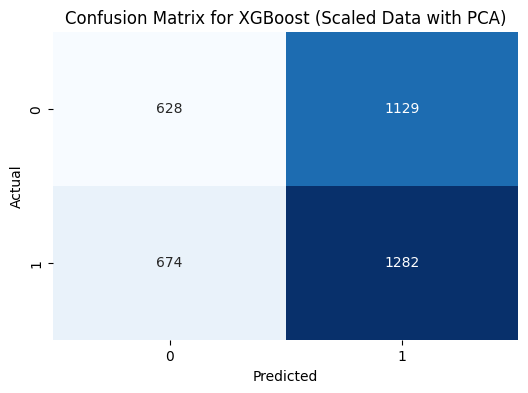

Classification Report (Scaled Data with PCA) for XGBoost:

              precision    recall  f1-score   support

           0       0.48      0.36      0.41      1757
           1       0.53      0.66      0.59      1956

    accuracy                           0.51      3713
   macro avg       0.51      0.51      0.50      3713
weighted avg       0.51      0.51      0.50      3713

--------------------------------------------------


In [29]:
# Train and evaluate models on both original and scaled data
for name, model in models.items():
    print(f"Training {name} on Scaled Data...")

    # Train and predict on original scaled data
    model.fit(X_train, y_train)
    preds_scaled = model.predict(X_test)
    acc_scaled = accuracy_score(y_test, preds_scaled)

    # Confusion Matrix for scaled data
    cm_scaled = confusion_matrix(y_test, preds_scaled)
    
    print(f"Confusion Matrix (Scaled Data) for {name}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_scaled, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {name} (Scaled Data)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report for scaled data
    print(f"Classification Report (Scaled Data) for {name}:\n")
    print(classification_report(y_test, preds_scaled))
    print("-" * 50)

    print(f"Training {name} on Scaled Data with PCA...")

    # Train and predict on PCA scaled data
    model.fit(X_scaled_pca, y_train)
    preds_scaled_pca = model.predict(X_test_pca)
    acc_scaled_pca = accuracy_score(y_test, preds_scaled_pca)

    # Confusion Matrix for scaled data with PCA
    cm_scaled_pca = confusion_matrix(y_test, preds_scaled_pca)
    
    print(f"Confusion Matrix (Scaled Data with PCA) for {name}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_scaled_pca, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {name} (Scaled Data with PCA)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report for scaled data with PCA
    print(f"Classification Report (Scaled Data with PCA) for {name}:\n")
    print(classification_report(y_test, preds_scaled_pca))
    print("-" * 50)
